# Arquitetura transformer

<a href='7181-attention-is-all-you-need.pdf'>Paper: Attention Is All You Need</a>

# Etapa 1: Importação das bibliotecas

In [1]:
import re
import math
import time
import random
import zipfile
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras import layers

# Etapa 2: Pré-processamento dos dados

## Carregamento da base de dados
* Bases de dados: https://www.statmt.org/europarl/

In [2]:
path = 'pt-en.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [3]:
with open('pt-en/europarl-v7.pt-en.en', mode='r', encoding='utf-8') as f:
    europarl_en = f.read()
with open('pt-en/europarl-v7.pt-en.pt', mode='r', encoding='utf-8') as f:
    europarl_pt = f.read()

In [4]:
europarl_en[0:100]

'Resumption of the session\nI declare resumed the session of the European Parliament adjourned on Frid'

In [5]:
en = europarl_en.split('\n')
len(en)

1960408

In [6]:
en

['Resumption of the session',
 'I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.',
 "Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.",
 'You have requested a debate on this subject in the course of the next few days, during this part-session.',
 "In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.",
 "Please rise, then, for this minute' s silence.",
 "(The House rose and observed a minute' s silence)",
 'Madam President, on a point of order.',
 'You will be aware from the press and television that there have be

In [7]:
pt = europarl_pt.split('\n')
len(pt)

1960408

In [8]:
sep_en = ' Sentença em inglês '
sep_pt = ' Tradução em português '
for _ in range(5):
    print(f'{sep_en.center(50,"=")}\n')
    i = random.randint(0, len(en) - 1)
    print(f'{en[i]}\n')
    print(f'{sep_pt.center(50,"-")}\n')
    print(f'{pt[i]}\n')

=============== Sentença em inglês ===============

The administrative detention of hundreds of thousands of people, systematic torture in prisons, religious and political repression, executions - all these methods are incompatible with the People's Republic of China's obligations as a member of the United Nations.

------------- Tradução em português --------------

A detenção administrativa de centenas de milhares de pessoas, a tortura sistemática nas prisões, a repressão religiosa e política, as execuções - tudo são métodos incompatíveis com as obrigações da República Popular da China como membro das Nações Unidas.

=============== Sentença em inglês ===============

Subject: Conflict Prevention and Peacekeeping in the Developing World How does the Development DG intend to cooperate with the Swedish Presidency on issues related to conflict prevention and peacekeeping in developing countries?

------------- Tradução em português --------------

Objecto: Prevenção de conflitos e manut

## Limpeza dos dados

In [9]:
def preprocess(corpus:str)->list:
    """
    Recebe o corpus do tipo String com os documentos separados por quebra de linha (\n)
    --------------------------------------------------------------------------
    -> Remove os pontos finais no meio da frase
    -> Remove o excesso de espaços
    -> Remove as quebras de linhas (\n)
    --------------------------------------------------------------------------
    Retorna a lista de documentos
    """
    
    corpus_cln = corpus
    corpus_cln = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", ".$$$", corpus_cln)
    corpus_cln = re.sub(r".\$\$\$", "", corpus_cln)
    corpus_cln = re.sub(r" +", " ", corpus_cln)
    corpus_cln = corpus_cln.split('\n')
    
    return corpus_cln

In [10]:
corpus_en = preprocess(europarl_en)
len(corpus_en)

1960408

In [11]:
corpus_pt = preprocess(europarl_pt)
len(corpus_pt)

1960408

## Tokenização

In [12]:
tokenizer_en = tfds.features.text.SubwordTextEncoder \
.build_from_corpus(corpus_en, target_vocab_size=2**13)

tokenizer_en.vocab_size

8191

In [13]:
tokenizer_pt = tfds.features.text.SubwordTextEncoder \
.build_from_corpus(corpus_pt, target_vocab_size=2**13)

tokenizer_pt.vocab_size

8116

In [14]:
vocab_size_en = tokenizer_en.vocab_size + 2
vocab_size_pt = tokenizer_pt.vocab_size + 2

In [15]:
inputs = [[vocab_size_en - 2] + tokenizer_en.encode(sentence) + [vocab_size_en - 1]
         for sentence in corpus_en]

for _ in range(5):
    print(inputs[random.randint(0, len(inputs) - 1)])

[8191, 11, 125, 8, 15, 35, 6067, 7967, 961, 6313, 4, 196, 24, 59, 19, 2330, 6716, 4, 1, 1391, 521, 729, 6, 2334, 2413, 7981, 8192]
[8191, 387, 157, 3629, 5909, 8050, 2, 217, 108, 1941, 2, 5, 64, 237, 8, 64, 48, 6380, 12, 181, 23, 5, 165, 501, 4, 233, 169, 66, 64, 2317, 7981, 8192]
[8191, 7405, 59, 19, 1720, 4, 6071, 709, 37, 3576, 7981, 8192]
[8191, 25, 413, 174, 24, 26, 3804, 2587, 7967, 590, 4, 227, 6, 283, 3, 1, 200, 90, 13, 161, 9, 8, 1, 302, 3, 170, 977, 9, 4136, 1992, 5, 80, 20, 26, 19, 2264, 1, 115, 409, 3, 1, 111, 7981, 8192]
[8191, 29, 44, 2, 66, 1668, 9, 1, 174, 3, 1, 357, 12, 6337, 2336, 444, 7998, 8192]


In [16]:
outputs = [[vocab_size_pt - 2] + tokenizer_pt.encode(sentence) + [vocab_size_pt - 1]
         for sentence in corpus_pt]

for _ in range(5):
    print(outputs[random.randint(0, len(outputs) - 1)])

[8116, 36, 286, 3211, 7928, 4330, 2086, 7892, 83, 4, 49, 262, 3160, 19, 12, 3863, 2894, 66, 3, 1149, 614, 1781, 1344, 48, 4407, 7892, 15, 2733, 3287, 1, 14, 484, 3967, 6, 8, 594, 1577, 1, 5, 3, 7774, 1573, 7, 7574, 7395, 7892, 11, 3, 984, 23, 6440, 226, 7906, 8117]
[8116, 87, 1416, 1, 793, 160, 2829, 10, 300, 4946, 7, 1326, 7906, 8117]
[8116, 68, 565, 4, 197, 5180, 19, 8, 5009, 2, 59, 9, 166, 7652, 79, 7906, 8117]
[8116, 481, 263, 1, 861, 7905, 16, 2, 13, 86, 630, 15, 3316, 4497, 79, 7906, 8117]
[8116, 4739, 1, 3, 120, 17, 18, 1430, 4213, 7892, 3, 117, 15, 849, 4300, 7975, 7906, 8117]


## Remoção de sentenças muito longas

In [17]:
max_length = 15
idx_to_remove = [idx for idx, sent in enumerate(inputs) if len(sent) > max_length]
len(idx_to_remove)

1685300

In [18]:
for idx in reversed(idx_to_remove):
    del inputs[idx]
    del outputs[idx]

len(inputs), len(outputs)

(275108, 275108)

In [19]:
idx_to_remove = [idx for idx, sent in enumerate(outputs) if len(sent) > max_length]
len(idx_to_remove)

66118

In [20]:
for idx in reversed(idx_to_remove):
    del inputs[idx]
    del outputs[idx]

len(inputs), len(outputs)

(208990, 208990)

## Padding e batches

In [21]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(
    inputs, value=0, padding = 'post', maxlen=max_length
    )

outputs = tf.keras.preprocessing.sequence.pad_sequences(
    outputs, value=0, padding = 'post', maxlen=max_length
    )

In [22]:
for _ in range(5):
    print(outputs[random.randint(0, len(outputs) - 1)])

[8116 4126 1122  704 7905 6058   47 3088  884 7906 8117    0    0    0
    0]
[8116  373    2 3966 7455 7892   84 3046 4098  226 7906 8117    0    0
    0]
[8116  353   35   41    1 1708   31   47 2932 7906 8117    0    0    0
    0]
[8116 7390   66 4612 7771 7892    2 1364   10  287 4903 7042 8117    0
    0]
[8116   30  410  408  363 1405    1   56 1679 7932 1515 7906 8117    0
    0]


from_tensor_slices: https://www.geeksforgeeks.org/tensorflow-tf-data-dataset-from_tensor_slices/

cache e prefetch: https://www.tensorflow.org/guide/data_performance

In [23]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Etapa 3: Construção do modelo

<img src='images/arquit_transformer.jpg' width ='350px'>

### Embedding

Positional encoding:

$PE_{(pos,2i)} =\sin(pos/10000^{2i/dmodel})$

$PE_{(pos,2i+1)} =\cos(pos/10000^{2i/dmodel})$

- The positional encodings have the same dimension dmodel
as the embeddings, so that the two can be summed

In [24]:
class PositionalEncoding(layers.Layer):
    
    def __init__(self):
        super(PositionalEncoding, self).__init__()
        
    def get_angles(self, pos, i, d_model):
        angles = 1 / np.power(10000., (2 * (i // 2)) / np.float32(d_model))
        return pos * angles # (seq_length, d_model)
    
    def call(self, inputs):
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                np.arange(d_model)[np.newaxis, :], d_model)
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        pos_encoding = angles[np.newaxis, ...]
        return inputs + tf.cast(pos_encoding, tf.float32)
        

## Mecanismo de atenção

### Cálculo da atenção

$Attention(Q, K, V ) = \text{softmax}\left(\dfrac{QK^T}{\sqrt{d_k}}\right)V $

### Scaled Dot-Product Attention
<img src="images/ScaledDotProductAttention.jpg" width='150px'>

In [25]:
def scaled_dot_product_attention(queries, keys, values, mask):
    product = tf.matmul(queries, keys, transpose_b=True)
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    scaled_product = product / tf.math.sqrt(keys_dim)
    
    if mask is not None:
        scaled_product += (mask * -1e9) # 0.0000000001
        
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), values)
    return attention

### Multi-head attention sublayer

<img src='images/MultiHeadAttention.jpg' width='350px'>

In [26]:
class MultiHeadAttention(layers.Layer):
    
    def __init__(self, nb_proj):
        super(MultiHeadAttention, self).__init__()
        
        self.nb_proj = nb_proj
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.nb_proj == 0
        
        self.d_proj = self.d_model // self.nb_proj
        
        self.query_lin = layers.Dense(units = self.d_model)
        self.key_lin = layers.Dense(units = self.d_model)
        self.value_lin = layers.Dense(units = self.d_model)
        
        self.final_lin = layers.Dense(units = self.d_model)
    
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        shape = (batch_size, -1, self.nb_proj, self.d_proj)
        splited_inputs = tf.reshape(inputs, shape = shape) # (batch_size, seq_length, nb_proj, d_proj)
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_projm seq_length, d_proj)
    
    def call(self, queries, keys, values, mask):
        batch_size = tf.shape(queries)[0]
        
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
        
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
        
        attention = scaled_dot_product_attention(queries, keys, values, mask)
        
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(attention, shape=(batch_size, -1, self.d_model))
        
        outputs = self.final_lin(concat_attention)
        
        return outputs

## Encoder

In [27]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, nb_proj, dropout_rate):
        super(EncoderLayer, self).__init__()
        
        self.FFN_units = FFN_units
        self.nb_proj = nb_proj
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        
        self.multi_head_attention = MultiHeadAttention(self.nb_proj)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6) # 0.0000001
        
        self.dense_1 = layers.Dense(units=self.FFN_units, activation='relu')
        self.dense_2 = layers.Dense(units=self.d_model, activation='relu')
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6) # 0.0000001       
    
    def call(self, inputs, mask, training):
        attention = self.multi_head_attention(inputs, inputs, inputs, mask)
        attention = self.dropout_1(attention, training = training)
        attention = self.norm_1(attention + inputs)
        
        outputs = self.dense_1(attention)
        outputs = self.dense_2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        outputs = self.norm_2(outputs + attention)
        
        return outputs

In [28]:
class Encoder(layers.Layer):
    
    def __init__(self,
                nb_layers,
                FFN_units,
                nb_proj,
                dropout_rate,
                vocab_size,
                d_model,
                name="encoder"):        
        super(Encoder, self).__init__(name=name)
        
        self.nb_layers = nb_layers
        self.d_model = d_model
        
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.enc_layers = [EncoderLayer(FFN_units, nb_proj, dropout_rate) for _ in range(nb_layers)]
    
    def call(self, inputs, mask, training):
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        
        for i in range(self.nb_layers):
            outputs = self.enc_layers[i](outputs, mask, training)
            
        return outputs
            

## Decoder

In [29]:
class DecoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, nb_proj, dropout_rate):
        super(DecoderLayer, self).__init__()
        
        self.FFN_units = FFN_units
        self.nb_proj = nb_proj
        self.dropout_rate = dropout_rate
        
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        
        self.multi_head_attention_1 = MultiHeadAttention(self.nb_proj)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        self.multi_head_attention_2 = MultiHeadAttention(self.nb_proj)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dense_1 = layers.Dense(units=self.FFN_units, activation = 'relu')
        self.dense_2 = layers.Dense(units=self.d_model, activation = 'relu')
        self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        attention = self.multi_head_attention_1(inputs, inputs, inputs, mask_1)
        attention = self.dropout_1(attention, training)
        attention = self.norm_1(attention + inputs)
        
        attention_2 = self.multi_head_attention_2(attention, enc_outputs, enc_outputs, mask_2)
        attention_2 = self.dropout_2(attention_2, training)
        attention_2 = self.norm_2(attention_2 + attention)
        
        outputs = self.dense_1(attention_2)
        outputs = self.dense_2(outputs)
        outputs = self.dropout_3(outputs, training)
        outputs = self.norm_3(outputs + attention_2)
        
        return outputs    

In [30]:
class Decoder(layers.Layer):
    
    def __init__(self,
                nb_layers,
                FFN_units,
                nb_proj,
                dropout_rate,
                vocab_size,
                d_model,
                name="decoder"):
        super(Decoder, self).__init__(name=name)
        
        self.d_model = d_model
        self.nb_layers = nb_layers
        
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        
        self.dec_layers = [DecoderLayer(FFN_units, nb_proj, dropout_rate) for i in range(nb_layers)]
        
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        
        for i in range(self.nb_layers):
            outputs = self.dec_layers[i](outputs, enc_outputs, mask_1, mask_2, training)
            
        return outputs

## Transformer

- Matriz triangular: https://mundoeducacao.bol.uol.com.br/matematica/matriz-triangular.htm

In [31]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                vocab_size_enc,
                vocab_size_dec,
                d_model,
                nb_layers,
                FFN_units,
                nb_proj,
                dropout_rate,
                name="transformer"):
        super(Transformer, self).__init__(name=name)
        
        self.encoder = Encoder(nb_layers, FFN_units, nb_proj, dropout_rate,
                              vocab_size_enc, d_model)
        self.decoder = Decoder(nb_layers, FFN_units, nb_proj, dropout_rate,
                              vocab_size_dec, d_model)
        self.last_linear = layers.Dense(units=vocab_size_dec, name='lin_output')
    
    def create_padding_mask(self, seq): # (batch_size, seq_length) -> (batch_size, nb_proj, seq_length, d_proj)
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]
    
    def create_look_ahead_mask(self, seq):
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask
    
    def call(self, enc_inputs, dec_inputs, training):
        enc_mask = self.create_padding_mask(enc_inputs)
        dec_mask_1 = tf.maximum(self.create_padding_mask(dec_inputs), self.create_look_ahead_mask(dec_inputs))
        dec_mask_2 = self.create_padding_mask(enc_inputs)
        
        enc_outputs = self.encoder(enc_inputs, enc_mask, training)
        dec_outputs = self.decoder(dec_inputs, enc_outputs, dec_mask_1, dec_mask_2, training)
        
        outputs = self.last_linear(dec_outputs)
        
        return outputs
    

In [32]:
# Somente para teste
def create_padding_mask(seq): # (batch_size, seq_length) -> (batch_size, nb_proj, seq_length, d_proj)
    mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(seq):
    seq_len = tf.shape(seq)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return look_ahead_mask

In [33]:
# Teste result
seq = tf.cast([[837,836,0,273,8,0,0,0]], tf.int32)
tf.maximum(create_padding_mask(seq), create_look_ahead_mask(seq))

<tf.Tensor: shape=(1, 1, 8, 8), dtype=float32, numpy=
array([[[[0., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1., 1., 1., 1.],
         [0., 0., 1., 0., 1., 1., 1., 1.],
         [0., 0., 1., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 1., 1., 1.]]]], dtype=float32)>

In [34]:
# Teste result
create_padding_mask(seq)

<tf.Tensor: shape=(1, 1, 1, 8), dtype=float32, numpy=array([[[[0., 0., 1., 0., 0., 1., 1., 1.]]]], dtype=float32)>

In [35]:
# Teste result
create_look_ahead_mask(seq)

<tf.Tensor: shape=(8, 8), dtype=float32, numpy=
array([[0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

## Treinamento

In [87]:
tf.keras.backend.clear_session()

D_MODEL = 128 # 512 recommended
NB_LAYERS = 4 # 6 recommended
FFN_UNITS = 512 # 2048 recommended
NB_PROJ = 8 # 8 recommended
DROPOUT_RATE = 0.1 # 0.1 recommended

In [88]:
transformer = Transformer(vocab_size_enc=vocab_size_en,
                         vocab_size_dec=vocab_size_pt,
                         d_model=D_MODEL,
                         nb_layers=NB_LAYERS,
                         FFN_units=FFN_UNITS,
                         nb_proj=NB_PROJ,
                         dropout_rate=DROPOUT_RATE)

In [89]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')

In [90]:
def loss_function(target, pred):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [91]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [92]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [93]:
learning_rate = CustomSchedule(D_MODEL)

In [94]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [95]:
checkpoint_path = "./ckpts_#2"
ckpt = tf.train.Checkpoint(transformer=transformer,
                          optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored")

In [96]:
EPOCHS = 10
hist = {'loss':[], 'acc':[]}
for epoch in range(EPOCHS):
    arr_loss = []
    arr_acc = []
    print(f'Start or epoch {epoch + 1}')
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (enc_inputs, targets)) in enumerate(dataset):
        dec_inputs = targets[:, :-1]
        dec_outputs_real = targets[:, 1:]
        with tf.GradientTape() as tape:
            predictions = transformer(enc_inputs, dec_inputs, True)
            loss = loss_function(dec_outputs_real, predictions)
        
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        
        train_loss(loss)
        train_accuracy(dec_outputs_real, predictions)
        
        if batch % 50 == 0:
            print("Epoch: {} | Batch: {} | Loss: {:.4f} | Accurracy: {:.4f}" \
                  .format(epoch+1, batch, train_loss.result(), train_accuracy.result()))
            
            arr_loss.append(train_loss.result().numpy())
            arr_acc.append(train_accuracy.result().numpy())
            
    hist['loss'].append(np.mean(arr_loss))
    hist['acc'].append(np.mean(arr_acc))
            
    ckpt_save_path = ckpt_manager.save()
    print(f"Saving checkpoint for epoch {epoch + 1} at {ckpt_save_path}")
    print(f"Time taken for 1 epoch {time.time() - start} secs\n")

Start or epoch 1
Epoch: 1 | Batch: 0 | Loss: 6.0352 | Accurracy: 0.0000
Epoch: 1 | Batch: 50 | Loss: 6.3831 | Accurracy: 0.0162
Epoch: 1 | Batch: 100 | Loss: 6.3169 | Accurracy: 0.0433
Epoch: 1 | Batch: 150 | Loss: 6.2405 | Accurracy: 0.0526
Epoch: 1 | Batch: 200 | Loss: 6.1345 | Accurracy: 0.0573
Epoch: 1 | Batch: 250 | Loss: 6.0360 | Accurracy: 0.0601
Epoch: 1 | Batch: 300 | Loss: 5.9093 | Accurracy: 0.0620
Epoch: 1 | Batch: 350 | Loss: 5.7844 | Accurracy: 0.0683
Epoch: 1 | Batch: 400 | Loss: 5.6499 | Accurracy: 0.0754
Epoch: 1 | Batch: 450 | Loss: 5.5297 | Accurracy: 0.0812
Epoch: 1 | Batch: 500 | Loss: 5.4120 | Accurracy: 0.0859
Epoch: 1 | Batch: 550 | Loss: 5.3052 | Accurracy: 0.0903
Epoch: 1 | Batch: 600 | Loss: 5.2022 | Accurracy: 0.0951
Epoch: 1 | Batch: 650 | Loss: 5.1035 | Accurracy: 0.1001
Epoch: 1 | Batch: 700 | Loss: 5.0098 | Accurracy: 0.1051
Epoch: 1 | Batch: 750 | Loss: 4.9240 | Accurracy: 0.1102
Epoch: 1 | Batch: 800 | Loss: 4.8460 | Accurracy: 0.1154
Epoch: 1 | Batch:

Epoch: 3 | Batch: 300 | Loss: 1.6666 | Accurracy: 0.4157
Epoch: 3 | Batch: 350 | Loss: 1.6551 | Accurracy: 0.4159
Epoch: 3 | Batch: 400 | Loss: 1.6423 | Accurracy: 0.4162
Epoch: 3 | Batch: 450 | Loss: 1.6290 | Accurracy: 0.4160
Epoch: 3 | Batch: 500 | Loss: 1.6221 | Accurracy: 0.4161
Epoch: 3 | Batch: 550 | Loss: 1.6164 | Accurracy: 0.4161
Epoch: 3 | Batch: 600 | Loss: 1.6113 | Accurracy: 0.4159
Epoch: 3 | Batch: 650 | Loss: 1.6069 | Accurracy: 0.4162
Epoch: 3 | Batch: 700 | Loss: 1.5960 | Accurracy: 0.4166
Epoch: 3 | Batch: 750 | Loss: 1.5909 | Accurracy: 0.4169
Epoch: 3 | Batch: 800 | Loss: 1.5846 | Accurracy: 0.4175
Epoch: 3 | Batch: 850 | Loss: 1.5797 | Accurracy: 0.4178
Epoch: 3 | Batch: 900 | Loss: 1.5756 | Accurracy: 0.4182
Epoch: 3 | Batch: 950 | Loss: 1.5700 | Accurracy: 0.4186
Epoch: 3 | Batch: 1000 | Loss: 1.5618 | Accurracy: 0.4190
Epoch: 3 | Batch: 1050 | Loss: 1.5531 | Accurracy: 0.4195
Epoch: 3 | Batch: 1100 | Loss: 1.5424 | Accurracy: 0.4199
Epoch: 3 | Batch: 1150 | Los

Epoch: 5 | Batch: 650 | Loss: 1.3019 | Accurracy: 0.4585
Epoch: 5 | Batch: 700 | Loss: 1.2945 | Accurracy: 0.4587
Epoch: 5 | Batch: 750 | Loss: 1.2885 | Accurracy: 0.4595
Epoch: 5 | Batch: 800 | Loss: 1.2858 | Accurracy: 0.4598
Epoch: 5 | Batch: 850 | Loss: 1.2805 | Accurracy: 0.4600
Epoch: 5 | Batch: 900 | Loss: 1.2770 | Accurracy: 0.4606
Epoch: 5 | Batch: 950 | Loss: 1.2710 | Accurracy: 0.4605
Epoch: 5 | Batch: 1000 | Loss: 1.2658 | Accurracy: 0.4608
Epoch: 5 | Batch: 1050 | Loss: 1.2607 | Accurracy: 0.4611
Epoch: 5 | Batch: 1100 | Loss: 1.2523 | Accurracy: 0.4617
Epoch: 5 | Batch: 1150 | Loss: 1.2456 | Accurracy: 0.4621
Epoch: 5 | Batch: 1200 | Loss: 1.2376 | Accurracy: 0.4626
Epoch: 5 | Batch: 1250 | Loss: 1.2310 | Accurracy: 0.4631
Epoch: 5 | Batch: 1300 | Loss: 1.2243 | Accurracy: 0.4635
Epoch: 5 | Batch: 1350 | Loss: 1.2185 | Accurracy: 0.4642
Epoch: 5 | Batch: 1400 | Loss: 1.2126 | Accurracy: 0.4646
Epoch: 5 | Batch: 1450 | Loss: 1.2077 | Accurracy: 0.4653
Epoch: 5 | Batch: 150

Epoch: 7 | Batch: 1000 | Loss: 1.1503 | Accurracy: 0.4777
Epoch: 7 | Batch: 1050 | Loss: 1.1448 | Accurracy: 0.4781
Epoch: 7 | Batch: 1100 | Loss: 1.1379 | Accurracy: 0.4783
Epoch: 7 | Batch: 1150 | Loss: 1.1324 | Accurracy: 0.4787
Epoch: 7 | Batch: 1200 | Loss: 1.1255 | Accurracy: 0.4791
Epoch: 7 | Batch: 1250 | Loss: 1.1197 | Accurracy: 0.4795
Epoch: 7 | Batch: 1300 | Loss: 1.1146 | Accurracy: 0.4798
Epoch: 7 | Batch: 1350 | Loss: 1.1089 | Accurracy: 0.4803
Epoch: 7 | Batch: 1400 | Loss: 1.1033 | Accurracy: 0.4810
Epoch: 7 | Batch: 1450 | Loss: 1.0986 | Accurracy: 0.4817
Epoch: 7 | Batch: 1500 | Loss: 1.0949 | Accurracy: 0.4823
Epoch: 7 | Batch: 1550 | Loss: 1.0904 | Accurracy: 0.4830
Epoch: 7 | Batch: 1600 | Loss: 1.0853 | Accurracy: 0.4836
Epoch: 7 | Batch: 1650 | Loss: 1.0814 | Accurracy: 0.4843
Epoch: 7 | Batch: 1700 | Loss: 1.0780 | Accurracy: 0.4849
Epoch: 7 | Batch: 1750 | Loss: 1.0736 | Accurracy: 0.4854
Epoch: 7 | Batch: 1800 | Loss: 1.0702 | Accurracy: 0.4859
Epoch: 7 | Bat

Epoch: 9 | Batch: 1350 | Loss: 1.0419 | Accurracy: 0.4901
Epoch: 9 | Batch: 1400 | Loss: 1.0372 | Accurracy: 0.4908
Epoch: 9 | Batch: 1450 | Loss: 1.0323 | Accurracy: 0.4914
Epoch: 9 | Batch: 1500 | Loss: 1.0284 | Accurracy: 0.4919
Epoch: 9 | Batch: 1550 | Loss: 1.0247 | Accurracy: 0.4923
Epoch: 9 | Batch: 1600 | Loss: 1.0209 | Accurracy: 0.4928
Epoch: 9 | Batch: 1650 | Loss: 1.0168 | Accurracy: 0.4935
Epoch: 9 | Batch: 1700 | Loss: 1.0130 | Accurracy: 0.4942
Epoch: 9 | Batch: 1750 | Loss: 1.0094 | Accurracy: 0.4949
Epoch: 9 | Batch: 1800 | Loss: 1.0062 | Accurracy: 0.4954
Epoch: 9 | Batch: 1850 | Loss: 1.0029 | Accurracy: 0.4959
Epoch: 9 | Batch: 1900 | Loss: 1.0006 | Accurracy: 0.4966
Epoch: 9 | Batch: 1950 | Loss: 0.9979 | Accurracy: 0.4972
Epoch: 9 | Batch: 2000 | Loss: 0.9950 | Accurracy: 0.4978
Epoch: 9 | Batch: 2050 | Loss: 0.9925 | Accurracy: 0.4985
Epoch: 9 | Batch: 2100 | Loss: 0.9908 | Accurracy: 0.4990
Epoch: 9 | Batch: 2150 | Loss: 0.9882 | Accurracy: 0.4997
Epoch: 9 | Bat

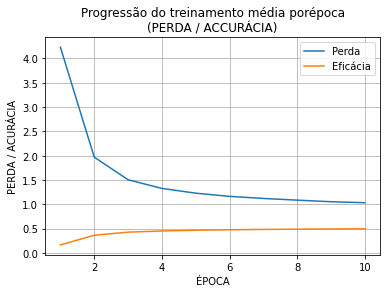

In [121]:
ax = plt.subplot()
plt.plot(list(range(1, EPOCHS+1)), hist['loss'], label = 'Perda')
plt.plot(list(range(1, EPOCHS+1)), hist['acc'], label = 'Eficácia')

ax.set(title = 'Progressão do treinamento média por época\n(PERDA / ACCURÁCIA)',
      xlabel = 'ÉPOCA', ylabel = 'PERDA / ACURÁCIA')
plt.legend()
plt.grid()
plt.show()

## Avaliação

In [108]:
text = 'you are smart'
text = [vocab_size_en - 2] + tokenizer_en.encode(text) + [vocab_size_en - 1]
text

[8191, 55, 17, 2202, 4099, 8192]

In [109]:
text = tf.expand_dims(text, axis = 0)
text.shape

TensorShape([1, 6])

In [110]:
output = tf.expand_dims([vocab_size_pt - 2], axis = 0)
output.shape

TensorShape([1, 1])

In [111]:
def evaluate(inp_sentence):
    inp_sentence = [vocab_size_en - 2] + tokenizer_en.encode(inp_sentence) + [vocab_size_en -1]
    enc_input = tf.expand_dims(inp_sentence, axis=0)
    
    output = tf.expand_dims([vocab_size_pt - 2], axis = 0)
    
    for _ in range(max_length):
        predictions = transformer(enc_input, output, False)
        prediction = predictions[:, -1:, :]
        
        prediction_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
        
        if prediction_id == vocab_size_pt - 1:
            return tf.squeeze(output, axis=0)
        
        output = tf.concat([output, prediction_id], axis=1)
        
    return tf.squeeze(output,axis = 0)

In [112]:
def translate(sentence):
    output = evaluate(sentence).numpy()
    
    predicted_sentence = tokenizer_pt.decode([i for i in output if i < vocab_size_pt - 2])
    
    print(f"Input: {sentence}")
    print(f"Predicted translation: {predicted_sentence}")

In [119]:
translate("i am happy")

Input: i am happy
Predicted translation: Agradeço-lhe protesto.


In [115]:
translate("this is a really powerful tool")

Input: this is a really powerful tool
Predicted translation: É um instrumento verdadeiramente poderoso.


In [116]:
translate("i am happy")

Input: i am happy
Predicted translation: Agradeço-lhe protesto.


In [118]:
translate("this is great news")

Input: this is great news
Predicted translation: São grandes notícias.


#### Melhorias:
* Utilizar a base de dados completa.
* Aumentar o tamanho das frases para o treinamento, média do tamanho das frases en e pt, neste caso foi de 15.
* Mudar os parâmetros.
* Aumentar o número de épocas

# FIM